In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
PLAYERS_DATA_URL = "https://raw.githubusercontent.com/Michael-R-Dickinson/DSCI-100-individual-project/refs/heads/main/players.csv"

# Download Data
download.file(PLAYERS_DATA_URL, "players.csv")

# Load Data
players_df <- read_csv('players.csv') 

# Clean Data

# Remove NA's and add levels to experience for visualization
players_df <- players_df |>
    filter(!is.na(Age)) |>
    mutate(
        "age" = Age,
        "subscribe" = as.factor(subscribe),
        "hashed_email" = hashedEmail,
        "experience" = factor(
            experience, 
            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"), 
        )
    ) |>
    select(-Age, -hashedEmail)

head(players_df)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,name,gender,age,hashed_email
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
Veteran,TRUE,3.8,Christian,Male,17,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
Veteran,FALSE,0.0,Blake,Male,17,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
Amateur,TRUE,0.7,Flora,Female,21,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5
Regular,TRUE,0.1,Kylie,Male,21,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e
Amateur,TRUE,0.0,Adrian,Female,17,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977


In [39]:
# If we want to use experience as a predictor, we will need to transform it into a numerical variable
# Heres the code to do that if thats helpful
players_df <- players_df |>
    mutate("experience" = as.numeric(experience))


players_datasets <- initial_split(players_df, prop = 0.8, strata = subscribe)
train_set <- training(players_datasets)
test_set <- testing(players_datasets)

folds <- vfold_cv(data = train_set, v = 5, strata = subscribe)

classification_recipe <- recipe(subscribe ~ played_hours + age + experience, data = players_df) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tune_grid <- tibble(neighbors = seq(from = 1, to = 30, by = 1))
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

classification_workflow <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = folds, grid = tune_grid)

metrics <- classification_workflow |> collect_metrics()

accuracies <- metrics |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

accuracy_by_neighbors_plot <- accuracies |> ggplot(aes(x = neighbors, y = mean)) +
    geom_line() + 
    geom_point() +
    labs(
        x = "Number of Neighbors", 
        y = "Cross Validation Accuracy",
        title = "Accuracy vs Number of Neighbors"
    ) + 
    theme(text = element_text(size = 20))

optimal_number_of_neighbors <- accuracies |>
    arrange(order_by = desc(mean)) |>
    slice(1) |>
    pull(neighbors)

optimal_knn_spec <-  nearest_neighbor(weight_func = "rectangular", neighbors = optimal_number_of_neighbors) |>
    set_engine("kknn") |>
    set_mode("classification")

optimal_workflow <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(optimal_knn_spec) |>
    fit(data = train_set)

test_set_metrics <- optimal_workflow |>
    predict(test_set) |>
    bind_cols(test_set) |>
    metrics(truth = subscribe, estimate = .pred_class)

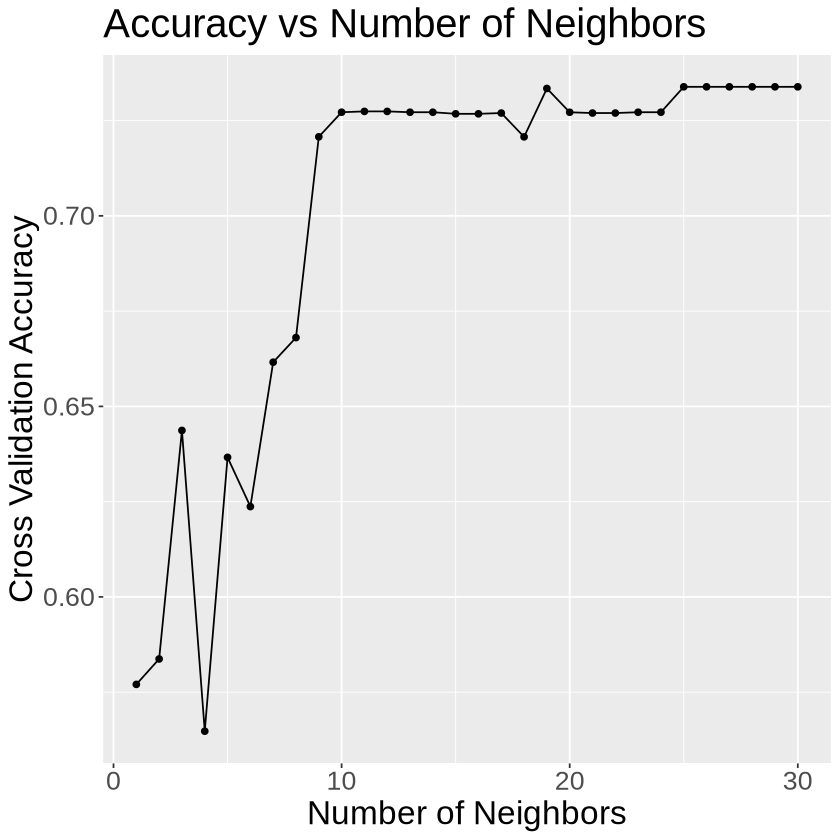

In [40]:
accuracy_by_neighbors_plot

In [41]:
test_set_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725
kap,binary,0.000
